In [5]:
pip install elasticsearch==8.12.1

  Obtaining dependency information for elasticsearch==8.12.1 from https://files.pythonhosted.org/packages/d6/6f/79f61e0c869363eccc85322b3004bee26ebabf038e84ce2798c872c69fa8/elasticsearch-8.12.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/432.1 kB ? eta -:--:--

In [1]:
import requests
import json
from kafka import KafkaProducer
from kafka import KafkaConsumer
from datetime import date, timedelta

### Recupération des données des 5 denières années depuis polygon.io

In [54]:
# Configuration Polygon
API_KEY = "lLLT5xaI5k8TNsMpstP3WDhGL8pkwbss"
TICKER = "AAPL"
END_DATE = date.today() - timedelta(days=1)
START_DATE = END_DATE - timedelta(days= 5*365)

# URL de l'API Polygon
url = f"https://api.polygon.io/v2/aggs/ticker/{TICKER}/range/1/day/{START_DATE}/{END_DATE}"
params = {
    "adjusted": "true",
    "sort": "asc",
    "limit": 5000,
    "apiKey": API_KEY
}

# Initialiser le producteur Kafka
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

# Appel API
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    results = data.get("results", [])

    if results:
        print(f"✅ {len(results)} résultat(s) trouvé(s) pour {TICKER} le {START_DATE} :\n")

        for d in results:
            message = {
                "ticker": TICKER,
                "timestamp": d["t"],
                "volume": d["v"],
                "close": d["c"],
                "open": d["o"],
                "high": d["h"],
                "low": d["l"]
            }

            # Envoi dans Kafka
            producer.send("finance-data", value=message)
            print("📤 Envoyé dans Kafka :", message)

        producer.flush()
    else:
        print(f"⚠️ Aucun résultat trouvé pour {TICKER} à la date {START_DATE}.")
else:
    print(f"❌ Erreur {response.status_code} : {response.text}")

✅ 501 résultat(s) trouvé(s) pour AAPL le 2020-06-07 :

📤 Envoyé dans Kafka : {'ticker': 'AAPL', 'timestamp': 1686196800000, 'volume': 50210681.0, 'close': 180.57, 'open': 177.895, 'high': 180.84, 'low': 177.46}
📤 Envoyé dans Kafka : {'ticker': 'AAPL', 'timestamp': 1686283200000, 'volume': 48869360.0, 'close': 180.96, 'open': 181.5, 'high': 182.23, 'low': 180.63}
📤 Envoyé dans Kafka : {'ticker': 'AAPL', 'timestamp': 1686542400000, 'volume': 54754995.0, 'close': 183.79, 'open': 181.27, 'high': 183.89, 'low': 180.97}
📤 Envoyé dans Kafka : {'ticker': 'AAPL', 'timestamp': 1686628800000, 'volume': 54867129.0, 'close': 183.31, 'open': 182.8, 'high': 184.15, 'low': 182.44}
📤 Envoyé dans Kafka : {'ticker': 'AAPL', 'timestamp': 1686715200000, 'volume': 57462782.0, 'close': 183.95, 'open': 183.37, 'high': 184.39, 'low': 182.02}
📤 Envoyé dans Kafka : {'ticker': 'AAPL', 'timestamp': 1686801600000, 'volume': 65433166.0, 'close': 186.01, 'open': 183.96, 'high': 186.52, 'low': 183.78}
📤 Envoyé dans Ka

In [55]:
# Initialiser le consommateur Kafka
consumer = KafkaConsumer(
    'finance-data',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='finance-display',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

print("📥 Consommateur Kafka lancé. En attente de messages...\n")

no_message_count = 0
MAX_NO_MESSAGE_COUNT = 3  # Arrêter après 3 tours sans message

while True:
    raw_messages = consumer.poll(timeout_ms=2000)

    if not raw_messages:
        no_message_count += 1
        print(f"⏳ Aucun message reçu (tentative {no_message_count}/{MAX_NO_MESSAGE_COUNT})...")
        if no_message_count >= MAX_NO_MESSAGE_COUNT:
            print("\n✅ Tous les messages ont été affichés. Fin du programme.")
            break
        continue

    for tp, messages in raw_messages.items():
        for message in messages:
            data = message.value
            print("📩 Message reçu :")
            print(f"  Ticker      : {data['ticker']}")
            print(f"  Timestamp   : {data['timestamp']}")
            print(f"  Volume      : {data['volume']}")
            print(f"  Open        : {data['open']}")
            print(f"  Close       : {data['close']}")
            print(f"  High / Low  : {data['high']} / {data['low']}")
            print("-" * 50)

    no_message_count = 0  # On a bien reçu des messages

consumer.close()


📥 Consommateur Kafka lancé. En attente de messages...

⏳ Aucun message reçu (tentative 1/3)...
📩 Message reçu :
  Ticker      : AAPL
  Timestamp   : 1686196800000
  Volume      : 50210681.0
  Open        : 177.895
  Close       : 180.57
  High / Low  : 180.84 / 177.46
--------------------------------------------------
📩 Message reçu :
  Ticker      : AAPL
  Timestamp   : 1686283200000
  Volume      : 48869360.0
  Open        : 181.5
  Close       : 180.96
  High / Low  : 182.23 / 180.63
--------------------------------------------------
📩 Message reçu :
  Ticker      : AAPL
  Timestamp   : 1686542400000
  Volume      : 54754995.0
  Open        : 181.27
  Close       : 183.79
  High / Low  : 183.89 / 180.97
--------------------------------------------------
📩 Message reçu :
  Ticker      : AAPL
  Timestamp   : 1686628800000
  Volume      : 54867129.0
  Open        : 182.8
  Close       : 183.31
  High / Low  : 184.15 / 182.44
--------------------------------------------------
📩 Message 

⏳ Aucun message reçu (tentative 1/3)...
⏳ Aucun message reçu (tentative 2/3)...
⏳ Aucun message reçu (tentative 3/3)...

✅ Tous les messages ont été affichés. Fin du programme.


### Envoi des données vers Elasticsearch

In [11]:
from elasticsearch import Elasticsearch

In [46]:
# Connexion à Elasticsearch
es = Elasticsearch("http://localhost:9200")

# Connexion au topic Kafka
consumer = KafkaConsumer(
    'finance-data',
    bootstrap_servers='localhost:9092',
    value_deserializer=lambda m: json.loads(m.decode('utf-8')),
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='finance-group'
)

print("📡 Lecture des messages Kafka et indexation dans Elasticsearch...\n")

# Compteur d'inactivité
no_message_count = 0
MAX_NO_MESSAGE_COUNT = 3  # Arrêt après 3 itérations sans messages
total_indexed = 0

while True:
    raw_messages = consumer.poll(timeout_ms=2000)

    if not raw_messages:
        no_message_count += 1
        print(f"⏳ Aucun nouveau message (tentative {no_message_count}/{MAX_NO_MESSAGE_COUNT})...")
        if no_message_count >= MAX_NO_MESSAGE_COUNT:
            print(f"\n✅ Fin de la consommation : {total_indexed} documents indexés au total.")
            break
        continue

    for tp, messages in raw_messages.items():
        for message in messages:
            doc = message.value
            print(f"📥 Message reçu : {doc}")

            # Indexation dans Elasticsearch
            res = es.index(index="polygon-index", document=doc)
            print(f"✅ Document indexé avec ID : {res['_id']}")
            total_indexed += 1

    no_message_count = 0  # On a lu des messages, on remet à zéro

consumer.close()

📡 Lecture des messages Kafka et indexation dans Elasticsearch...

⏳ Aucun nouveau message (tentative 1/3)...
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1686196800000, 'volume': 50210681.0, 'close': 180.57, 'open': 177.895, 'high': 180.84, 'low': 177.46}
✅ Document indexé avec ID : 7Wk0SpcBZAvdhMjzLIXk
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1686283200000, 'volume': 48869360.0, 'close': 180.96, 'open': 181.5, 'high': 182.23, 'low': 180.63}
✅ Document indexé avec ID : 7mk0SpcBZAvdhMjzLYUw
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1686542400000, 'volume': 54754995.0, 'close': 183.79, 'open': 181.27, 'high': 183.89, 'low': 180.97}
✅ Document indexé avec ID : 72k0SpcBZAvdhMjzLYV_
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1686628800000, 'volume': 54867129.0, 'close': 183.31, 'open': 182.8, 'high': 184.15, 'low': 182.44}
✅ Document indexé avec ID : 8Gk0SpcBZAvdhMjzLYW7
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1686715200000, 'volume': 57462782.0, 'close': 1

✅ Document indexé avec ID : F2k0SpcBZAvdhMjzOIY_
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1691640000000, 'volume': 54686851.0, 'close': 177.97, 'open': 179.48, 'high': 180.75, 'low': 177.6}
✅ Document indexé avec ID : GGk0SpcBZAvdhMjzOIaD
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1691726400000, 'volume': 51036672.0, 'close': 177.79, 'open': 177.32, 'high': 178.62, 'low': 176.55}
✅ Document indexé avec ID : GWk0SpcBZAvdhMjzOIbD
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1691985600000, 'volume': 43675627.0, 'close': 179.46, 'open': 177.97, 'high': 179.69, 'low': 177.305}
✅ Document indexé avec ID : Gmk0SpcBZAvdhMjzOYYD
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1692072000000, 'volume': 43574863.0, 'close': 177.45, 'open': 178.88, 'high': 179.48, 'low': 177.05}
✅ Document indexé avec ID : G2k0SpcBZAvdhMjzOYY7
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1692158400000, 'volume': 45712957.0, 'close': 176.57, 'open': 177.13, 'high': 178.54, 'low': 176.5}
✅ Docu

✅ Document indexé avec ID : Qmk0SpcBZAvdhMjzQ4YM
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1696996800000, 'volume': 47544848.0, 'close': 179.8, 'open': 178.2, 'high': 179.85, 'low': 177.6}
✅ Document indexé avec ID : Q2k0SpcBZAvdhMjzQ4ZL
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1697083200000, 'volume': 56743119.0, 'close': 180.71, 'open': 180.07, 'high': 182.34, 'low': 179.04}
✅ Document indexé avec ID : RGk0SpcBZAvdhMjzQ4aL
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1697169600000, 'volume': 51412082.0, 'close': 178.85, 'open': 181.42, 'high': 181.93, 'low': 178.14}
✅ Document indexé avec ID : RWk0SpcBZAvdhMjzQ4bK
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1697428800000, 'volume': 52516984.0, 'close': 178.72, 'open': 176.75, 'high': 179.075, 'low': 176.51}
✅ Document indexé avec ID : Rmk0SpcBZAvdhMjzRIYG
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1697515200000, 'volume': 57549350.0, 'close': 177.15, 'open': 176.645, 'high': 178.42, 'low': 174.8}
✅ Docum

✅ Document indexé avec ID : bmk0SpcBZAvdhMjzTYaX
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1702443600000, 'volume': 70404183.0, 'close': 197.96, 'open': 195.09, 'high': 198, 'low': 194.85}
✅ Document indexé avec ID : b2k0SpcBZAvdhMjzTYbX
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1702530000000, 'volume': 66831572.0, 'close': 198.11, 'open': 198.02, 'high': 199.62, 'low': 196.16}
✅ Document indexé avec ID : cGk0SpcBZAvdhMjzToYb
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1702616400000, 'volume': 127387901.0, 'close': 197.57, 'open': 197.53, 'high': 198.3999, 'low': 197}
✅ Document indexé avec ID : cWk0SpcBZAvdhMjzToZp
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1702875600000, 'volume': 55751861.0, 'close': 195.89, 'open': 196.09, 'high': 196.63, 'low': 194.39}
✅ Document indexé avec ID : cmk0SpcBZAvdhMjzToa4
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1702962000000, 'volume': 40714051.0, 'close': 196.94, 'open': 196.16, 'high': 196.95, 'low': 195.89}
✅ Docume

✅ Document indexé avec ID : l2k0SpcBZAvdhMjzWIZf
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1707800400000, 'volume': 56529529.0, 'close': 185.04, 'open': 185.77, 'high': 186.21, 'low': 183.5128}
✅ Document indexé avec ID : mGk0SpcBZAvdhMjzWIak
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1707886800000, 'volume': 54617917.0, 'close': 184.15, 'open': 185.32, 'high': 185.53, 'low': 182.44}
✅ Document indexé avec ID : mWk0SpcBZAvdhMjzWIbv
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1707973200000, 'volume': 65434496.0, 'close': 183.86, 'open': 183.55, 'high': 184.49, 'low': 181.35}
✅ Document indexé avec ID : mmk0SpcBZAvdhMjzWYYx
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1708059600000, 'volume': 49752465.0, 'close': 182.31, 'open': 183.42, 'high': 184.85, 'low': 181.665}
✅ Document indexé avec ID : m2k0SpcBZAvdhMjzWYZ3
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1708405200000, 'volume': 53574453.0, 'close': 181.56, 'open': 181.79, 'high': 182.43, 'low': 180}
✅ Doc

✅ Document indexé avec ID : wGk0SpcBZAvdhMjzY4ZN
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1712894400000, 'volume': 101282386.0, 'close': 176.55, 'open': 174.26, 'high': 178.36, 'low': 174.21}
✅ Document indexé avec ID : wWk0SpcBZAvdhMjzY4aZ
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1713153600000, 'volume': 73498773.0, 'close': 172.69, 'open': 175.36, 'high': 176.63, 'low': 172.5}
✅ Document indexé avec ID : wmk0SpcBZAvdhMjzY4bl
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1713240000000, 'volume': 73665235.0, 'close': 169.38, 'open': 171.75, 'high': 173.76, 'low': 168.27}
✅ Document indexé avec ID : w2k0SpcBZAvdhMjzZIYy
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1713326400000, 'volume': 50351210.0, 'close': 168, 'open': 169.61, 'high': 170.65, 'low': 168}
✅ Document indexé avec ID : xGk0SpcBZAvdhMjzZIaB
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1713412800000, 'volume': 43103753.0, 'close': 167.04, 'open': 168.03, 'high': 168.64, 'low': 166.55}
✅ Document 

✅ Document indexé avec ID : 62k0SpcBZAvdhMjzb4YR
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1718251200000, 'volume': 97750229.0, 'close': 214.24, 'open': 214.74, 'high': 216.75, 'low': 211.6}
✅ Document indexé avec ID : 7Gk0SpcBZAvdhMjzb4Zc
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1718337600000, 'volume': 70108898.0, 'close': 212.49, 'open': 213.85, 'high': 215.17, 'low': 211.3}
✅ Document indexé avec ID : 7Wk0SpcBZAvdhMjzb4at
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1718596800000, 'volume': 93689100.0, 'close': 216.67, 'open': 213.37, 'high': 218.95, 'low': 212.72}
✅ Document indexé avec ID : 7mk0SpcBZAvdhMjzb4b4
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1718683200000, 'volume': 79943254.0, 'close': 214.29, 'open': 217.59, 'high': 218.63, 'low': 213}
✅ Document indexé avec ID : 72k0SpcBZAvdhMjzcIZF
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1718856000000, 'volume': 86095783.0, 'close': 209.68, 'open': 213.93, 'high': 214.24, 'low': 208.85}
✅ Document

✅ Document indexé avec ID : F2k0SpcBZAvdhMjzeoe0
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1723780800000, 'volume': 44338440.0, 'close': 226.05, 'open': 223.92, 'high': 226.8271, 'low': 223.6501}
✅ Document indexé avec ID : GGk0SpcBZAvdhMjzeof2
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1724040000000, 'volume': 40687813.0, 'close': 225.89, 'open': 225.72, 'high': 225.99, 'low': 223.04}
✅ Document indexé avec ID : GWk0SpcBZAvdhMjze4c9
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1724126400000, 'volume': 30299033.0, 'close': 226.51, 'open': 225.77, 'high': 227.17, 'low': 225.45}
✅ Document indexé avec ID : Gmk0SpcBZAvdhMjze4d_
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1724212800000, 'volume': 34765480.0, 'close': 226.4, 'open': 226.52, 'high': 227.98, 'low': 225.05}
✅ Document indexé avec ID : G2k0SpcBZAvdhMjze4fJ
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1724299200000, 'volume': 43673321.0, 'close': 224.53, 'open': 227.79, 'high': 228.34, 'low': 223.9}
✅ D

✅ Document indexé avec ID : RGk0SpcBZAvdhMjzh4eB
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1729483200000, 'volume': 36254470.0, 'close': 236.48, 'open': 234.45, 'high': 236.85, 'low': 234.45}
✅ Document indexé avec ID : RWk0SpcBZAvdhMjzh4fG
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1729569600000, 'volume': 38846578.0, 'close': 235.86, 'open': 233.885, 'high': 236.22, 'low': 232.6}
✅ Document indexé avec ID : Rmk0SpcBZAvdhMjziIcM
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1729656000000, 'volume': 52286979.0, 'close': 230.76, 'open': 234.08, 'high': 235.144, 'low': 227.76}
✅ Document indexé avec ID : R2k0SpcBZAvdhMjziIdS
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1729742400000, 'volume': 31109503.0, 'close': 230.57, 'open': 229.98, 'high': 230.82, 'low': 228.41}
✅ Document indexé avec ID : SGk0SpcBZAvdhMjziIeZ
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1729828800000, 'volume': 38602304.0, 'close': 231.41, 'open': 229.74, 'high': 233.22, 'low': 229.57}
✅ Do

✅ Document indexé avec ID : cGk0SpcBZAvdhMjzk4dC
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1734930000000, 'volume': 40858774.0, 'close': 255.27, 'open': 254.77, 'high': 255.65, 'low': 253.45}
✅ Document indexé avec ID : cWk0SpcBZAvdhMjzk4eA
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1735016400000, 'volume': 23234705.0, 'close': 258.2, 'open': 255.49, 'high': 258.21, 'low': 255.29}
✅ Document indexé avec ID : cmk0SpcBZAvdhMjzk4e7
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1735189200000, 'volume': 27262983.0, 'close': 259.02, 'open': 258.19, 'high': 260.1, 'low': 257.63}
✅ Document indexé avec ID : c2k0SpcBZAvdhMjzk4f5
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1735275600000, 'volume': 42355321.0, 'close': 255.59, 'open': 257.83, 'high': 258.7, 'low': 253.06}
✅ Document indexé avec ID : dGk0SpcBZAvdhMjzlIcz
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1735534800000, 'volume': 35557542.0, 'close': 252.2, 'open': 252.23, 'high': 253.5, 'low': 250.75}
✅ Document

✅ Document indexé avec ID : mmk0SpcBZAvdhMjznod-
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1740546000000, 'volume': 44433564.0, 'close': 240.36, 'open': 244.33, 'high': 244.98, 'low': 239.13}
✅ Document indexé avec ID : m2k0SpcBZAvdhMjznofF
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1740632400000, 'volume': 41153639.0, 'close': 237.3, 'open': 239.41, 'high': 242.46, 'low': 237.06}
✅ Document indexé avec ID : nGk0SpcBZAvdhMjzn4cO
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1740718800000, 'volume': 56833349.0, 'close': 241.84, 'open': 236.95, 'high': 242.09, 'low': 230.2}
✅ Document indexé avec ID : nWk0SpcBZAvdhMjzn4dX
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1740978000000, 'volume': 47183985.0, 'close': 238.03, 'open': 241.79, 'high': 244.0272, 'low': 236.112}
✅ Document indexé avec ID : nmk0SpcBZAvdhMjzn4eh
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1741064400000, 'volume': 53798024.0, 'close': 235.93, 'open': 237.705, 'high': 240.07, 'low': 234.68}
✅ D

✅ Document indexé avec ID : xGk0SpcBZAvdhMjzqYfk
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1745812800000, 'volume': 38737224.0, 'close': 210.14, 'open': 210, 'high': 211.5, 'low': 207.46}
✅ Document indexé avec ID : xWk0SpcBZAvdhMjzqocg
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1745899200000, 'volume': 36827633.0, 'close': 211.21, 'open': 208.693, 'high': 212.24, 'low': 208.37}
✅ Document indexé avec ID : xmk0SpcBZAvdhMjzqode
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1745985600000, 'volume': 52286454.0, 'close': 212.5, 'open': 209.3, 'high': 213.58, 'low': 206.6705}
✅ Document indexé avec ID : x2k0SpcBZAvdhMjzqoeq
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1746072000000, 'volume': 57364925.0, 'close': 213.32, 'open': 209.08, 'high': 214.56, 'low': 208.9}
✅ Document indexé avec ID : yGk0SpcBZAvdhMjzqof2
📥 Message reçu : {'ticker': 'AAPL', 'timestamp': 1746158400000, 'volume': 101010621.0, 'close': 205.35, 'open': 206.09, 'high': 206.99, 'low': 202.16}
✅ Docume

### Création du modèle sur la base des données envoyées à Elasticsearch

In [15]:
from elasticsearch.helpers import scan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Importation des données depuis Elasticsearch

In [56]:
es = Elasticsearch("http://localhost:9200")

results = scan(es, index="polygon-index", query={"query": {"match_all": {}}})
data = pd.DataFrame([doc['_source'] for doc in results])
data.shape

(2533, 7)

In [57]:
print(data.head())

  ticker      timestamp      volume   close     open      high       low
0   AAPL  1734066000000  33081590.0  248.13  247.815  249.2902  246.2400
1   AAPL  1734325200000  51694753.0  251.04  247.990  251.3800  247.6500
2   AAPL  1734411600000  51356360.0  253.48  250.080  253.8300  249.7800
3   AAPL  1734498000000  56764701.0  248.05  252.160  254.2800  247.7400
4   AAPL  1734584400000  60559114.0  249.79  247.500  252.0000  247.0949


Préparation et séparation des des données

In [58]:
X = data[['volume']]        # Variable explicative
y = data['close']           # Variable cible

# 4. Séparer en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Création et entrainement du modèle

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

Evaluation des modèles

In [60]:
print("🔍 Évaluation du modèle :")
print("Score R² :", r2_score(y_test, y_pred))
print("Erreur quadratique moyenne :", mean_squared_error(y_test, y_pred))

🔍 Évaluation du modèle :
Score R² : 0.033092139804148935
Erreur quadratique moyenne : 512.7742193273415


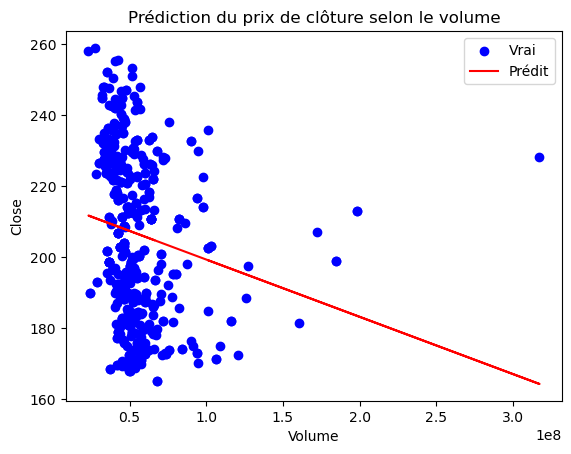

In [61]:
plt.scatter(X_test, y_test, color='blue', label='Vrai')
plt.plot(X_test, y_pred, color='red', label='Prédit')
plt.xlabel('Volume')
plt.ylabel('Close')
plt.title('Prédiction du prix de clôture selon le volume')
plt.legend()
plt.show()

### Random Forest Regressor

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² :", r2_score(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))


R² : 0.9823421404627342
MSE : 9.364382597302859


###  Gradient Boosting Regressor

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² :", r2_score(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))

R² : 0.40194451672465736
MSE : 317.16303711589757
